# What are the most demanded skills for the selected data roles?

## Data loading

In [71]:
import ast 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from matplotlib.ticker import PercentFormatter

# Load data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Drop duplicates
df = df.drop_duplicates()

# Convert date to datetime
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])

# Convert df['job_skills'] from a string to a list of strings
convert_skills = lambda x: ast.literal_eval(x) if pd.notna(x) else x
df['job_skills'] = df['job_skills'].apply(convert_skills)

In [72]:
# Placeholder in case we want to pre-filter data before analysis
# (e.g., based on job_country for instance)
df_relevant = df.copy()

## Likelihood of skills being requested in selected data role 

We compute the skill count per job title (_i.e._, the number of times a skill is requested for a given job title).

In [91]:
# Explode skills (which are initially contained in lists within 'job_skills')
df_skills = df_relevant.explode('job_skills')

# Group by job_skills and job_title_short and count the number of occurrences
df_skills = df_skills.groupby(['job_skills', 'job_title_short']).size()

# Rename the count column as skill_count
df_skills = df_skills.reset_index(name='skill_count')

# Sort the values by skill_count in descending order
df_skills = df_skills.sort_values('skill_count', ascending=False)

Given counts do not show the actual proportion of jobs that are requesting the above skills, we also compute the likelihood for these skills to be requested. Here, we define these skill likelihoods as the ratio between the above skill counts and the number of job postings associated with a given job title.

In [92]:
# Compute the count of job titles
df_jobs = df_relevant['job_title_short'].value_counts()

# Rename count to job_count
df_jobs = df_jobs.reset_index(name='job_count')

# Merge df_skills and df_jobs
# (Ensures that, for a given a job title, each skill count 
#  is associated with the total number of job postings)
df_skills_job = pd.merge(df_skills, df_jobs, on='job_title_short', how='left')

# Compute likelihood
df_skills_job['skill_likelihood'] \
    = 100*(df_skills_job['skill_count']/df_skills_job['job_count'])

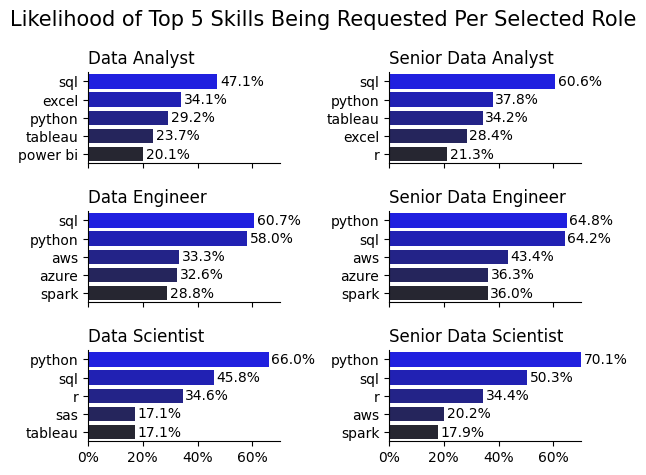

In [94]:
# Plot
job_title_array = [['Data Analyst', 'Senior Data Analyst'],
                   ['Data Engineer', 'Senior Data Engineer'],
                   ['Data Scientist', 'Senior Data Scientist']]
n_skills = 5

fig, ax = plt.subplots(len(job_title_array), len(job_title_array[0]))
for i, job_titles in enumerate(job_title_array):
    for j, job_title in enumerate(job_titles):
        idx = (df_skills_job['job_title_short'] == job_title)
        df_plot = df_skills_job[idx].head(n_skills)

        sns.barplot(df_plot, x='skill_likelihood', y='job_skills', ax=ax[i][j],
                    hue='job_skills', palette='dark:b_r', legend=False)
        sns.despine()

        ax[i][j].set_title(job_title, loc='left')
        ax[i][j].set_ylabel('')
        ax[i][j].set_xlabel('')
        ax[i][j].set_xlim(0, 70)

        # Add likelihood values to each bar
        for idx, val in enumerate(df_plot['skill_likelihood']):   
            ax[i][j].text(val+1, idx, f'{val:.1f}%', va='center')

        # For readability
        if i < len(job_titles):
            ax[i][j].set_xticklabels([])
        else:
            ax[i][j].xaxis.set_major_formatter(PercentFormatter(decimals=0))

fig.suptitle(f'Likelihood of Top {n_skills} Skills Being Requested Per Selected Role',
             fontsize=15)
fig.tight_layout(h_pad=1.5, w_pad=1.2)
plt.show()

**Breakdown:**
- As expected, senior roles have more skill expectations than standard roles, with skill likelihoods being typically higher for senior roles.
- There seems to be a lot of variety in the skillsets requested for data-analyst roles, as no skill is requested more often than not (_i.e._, likelihood above 50%).
- `python` is requested more often than not for senior-data-analyst, (senior)-data-engineer and (senior)-data-scientist roles.
- `sql` is requested more often than not for senior-data-analyst, (senior)-data-engineer and senior-data-scientist roles.
- (Senior)-data-analyst job postings mostly request fundamental data-handling/analysis (`sql`, `excel`, `python`) and data-visualization (`tableau`/`power bi`) tools, with `sql` being the most requested tool.
- (Senior)-data-engineer job postings mostly request `sql` and `python`, but also cloud-platform tools such as `aws`, `azure` and `spark`.
- (Senior)-data-scientist job postings mostly request `python`, `sql` and `r`, but one can see a shift toward cloud-platform tools (`aws`, `spark`) with higher seniority.